# Model LifeCycle AT- Predição de Risco de Diabetes

**Aluno:** Gabriel Tauber  
**Disciplina:** Inteligência Artificial: Model Lifecycle  
**Dataset:** CDC Behavioral Risk Factor Surveillance

---
## Questão 1: Estruturação Conceitual do Problema de Modelagem

### 1A/1B) Por que este é um problema de classificação supervisionada?

Este problema deve ser tratado como **classificação supervisionada** porque:

1. **Variável-alvo disponível:** Temos a variável `Diabetes_binary` que indica se o indivíduo tem diabetes (1) ou não (0), caracterizando um problema binário com rótulos conhecidos.

2. **Dados rotulados:** Cada registro possui um diagnóstico confirmado, permitindo que o modelo aprenda padrões a partir de exemplos históricos.

3. **Objetivo de predição categórica:** Queremos classificar novos indivíduos em duas categorias (com/sem diabetes) a partir de suas características clínicas e comportamentais.

### 1C) Desafios para aplicação de modelos supervisionados

**1. Desbalanceamento de classes:**  
A diabetes afeta uma parcela minoritária da população, o que pode resultar em classes desproporcionais. Isso pode fazer o modelo ter viés para a classe majoritária.

**2. Necessidade de normalização:**  
As variáveis possuem escalas diferentes (ex: BMI varia de ~10 a ~100, enquanto variáveis binárias são 0/1). Algoritmos baseados em distância como KNN são sensíveis a isso.

### 1D) Bibliotecas utilizadas

| Biblioteca | Função |
|------------|--------|
| **ucimlrepo** | Carregamento do dataset diretamente do repositório UCI |
| **pandas/numpy** | Manipulação e análise de dados |
| **scikit-learn** | Modelos de ML, pré-processamento, métricas e validação cruzada |
| **matplotlib/seaborn** | Visualização de dados e resultados |

---
## Questão 2: Implementação do Modelo K-Nearest Neighbors

In [ ]:
!pip install ucimlrepo -q

In [1]:
# Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')

### 2A) Carregamento dos dados e seleção de variáveis

In [2]:
# Carregamento do dataset
cdc_diabetes = fetch_ucirepo(id=891)

X = cdc_diabetes.data.features
y = cdc_diabetes.data.targets.values.ravel()

print(f"Dimensões: {X.shape[0]} registros, {X.shape[1]} variáveis")
print(f"\nVariáveis explicativas: {list(X.columns)}")
print(f"\nDistribuição da variável-alvo:")
print(pd.Series(y).value_counts(normalize=True).round(3))

Dimensões: 253680 registros, 21 variáveis

Variáveis explicativas: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Distribuição da variável-alvo:
0    0.861
1    0.139
Name: proportion, dtype: float64


**Justificativa:** Utilizamos todas as 21 variáveis disponíveis, pois todas têm relevância clínica para predição de diabetes (indicadores de saúde, hábitos e dados demográficos). O desbalanceamento observado (~86% não-diabéticos) confirma o desafio identificado na Questão 1C.

### 2B) Separação treino/teste com estratificação

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {len(X_train)} amostras")
print(f"Teste: {len(X_test)} amostras")
print(f"\nProporção de diabéticos no treino: {y_train.mean():.3f}")
print(f"Proporção de diabéticos no teste: {y_test.mean():.3f}")

Treino: 202944 amostras
Teste: 50736 amostras

Proporção de diabéticos no treino: 0.139
Proporção de diabéticos no teste: 0.139


A estratificação (`stratify=y`) garante que a proporção entre classes seja mantida em ambos os conjuntos. Isso é fundamental em dados desbalanceados para evitar que um conjunto fique sem representantes de uma classe.

### 2C) Normalização dos dados

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Antes da normalização (amostra do treino):")
print(f"Média BMI: {X_train['BMI'].mean():.2f}, Desvio: {X_train['BMI'].std():.2f}")
print(f"\nApós normalização:")
print(f"Média: {X_train_scaled.mean():.2f}, Desvio: {X_train_scaled.std():.2f}")

Antes da normalização (amostra do treino):
Média BMI: 28.38, Desvio: 6.60

Após normalização:
Média: 0.00, Desvio: 1.00


A normalização é **essencial para o KNN** porque o algoritmo calcula distâncias entre pontos. Sem normalização, variáveis com maior escala dominariam o cálculo da distância, prejudicando o modelo.

### 2D) Treinamento e avaliação do KNN

In [5]:
# Testando diferentes valores de K
k_values = [3, 5, 7, 9, 11, 15]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'K': k, 'Acurácia': acc, 'F1-Score': f1})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 K  Acurácia  F1-Score
 3  0.836743  0.293802
 5  0.847524  0.281975
 7  0.852117  0.267643
 9  0.854876  0.251956
11  0.856138  0.239450
15  0.859291  0.223769


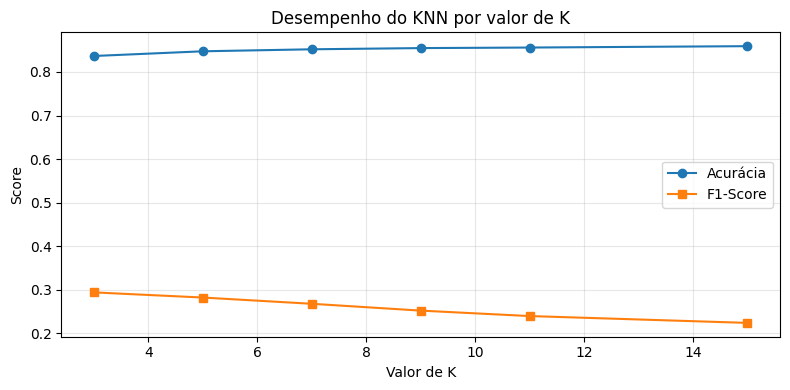

In [6]:
# Visualização
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results_df['K'], results_df['Acurácia'], 'o-', label='Acurácia')
ax.plot(results_df['K'], results_df['F1-Score'], 's-', label='F1-Score')
ax.set_xlabel('Valor de K')
ax.set_ylabel('Score')
ax.set_title('Desempenho do KNN por valor de K')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Seleção do melhor K baseado no F1-Score
best_k = results_df.loc[results_df['F1-Score'].idxmax(), 'K']
print(f"Melhor K selecionado: {int(best_k)}")

# Modelo final KNN
knn_final = KNeighborsClassifier(n_neighbors=int(best_k))
knn_final.fit(X_train_scaled, y_train)

Melhor K selecionado: 3


,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


O valor de K foi escolhido com base no **F1-Score**, que é mais adequado para dados desbalanceados. Valores muito baixos de K tendem a overfitting, enquanto valores muito altos tendem a underfitting.

---
## Questão 3: Validação Cruzada e Comparação entre Modelos

### 3A) Validação cruzada no KNN

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_cv = KNeighborsClassifier(n_neighbors=int(best_k))
scores_knn = cross_val_score(knn_cv, X_train_scaled, y_train, cv=cv, scoring='f1')

print(f"KNN (K={int(best_k)}) - Validação Cruzada (5-fold):")
print(f"F1-Scores: {scores_knn.round(4)}")
print(f"Média: {scores_knn.mean():.4f} (+/- {scores_knn.std()*2:.4f})")

KNN (K=3) - Validação Cruzada (5-fold):
F1-Scores: [0.2806 0.2892 0.2853 0.2987 0.2798]
Média: 0.2867 (+/- 0.0137)


A validação cruzada estratificada (5 dobras) permite estimar o desempenho real do modelo em dados não vistos, reduzindo o viés de uma única divisão treino/teste. Usamos F1-Score como métrica por ser mais apropriada para dados desbalanceados.

### 3B) Modelo adicional: Regressão Logística

In [9]:
lr = LogisticRegression(max_iter=1000, random_state=42)
scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring='f1')

print(f"Regressão Logística - Validação Cruzada (5-fold):")
print(f"F1-Scores: {scores_lr.round(4)}")
print(f"Média: {scores_lr.mean():.4f} (+/- {scores_lr.std()*2:.4f})")

Regressão Logística - Validação Cruzada (5-fold):
F1-Scores: [0.2405 0.2333 0.2461 0.2592 0.2424]
Média: 0.2443 (+/- 0.0170)


### 3C) Comparação dos modelos

In [10]:
comparison = pd.DataFrame({
    'Modelo': ['KNN', 'Regressão Logística'],
    'F1 Médio': [scores_knn.mean(), scores_lr.mean()],
    'Desvio Padrão': [scores_knn.std(), scores_lr.std()]
})
print(comparison.to_string(index=False))

             Modelo  F1 Médio  Desvio Padrão
                KNN  0.286734       0.006870
Regressão Logística  0.244297       0.008523


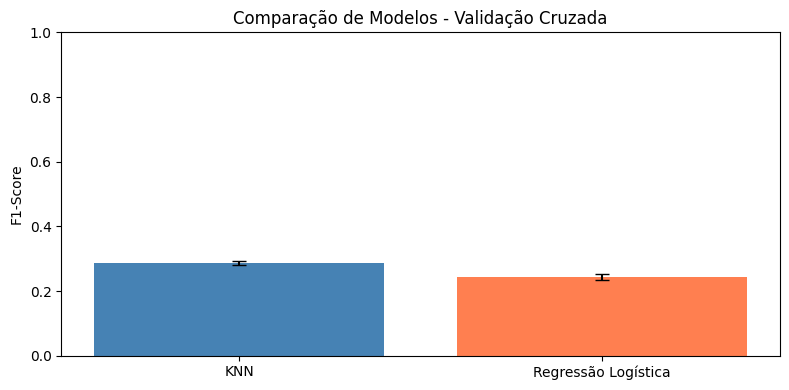

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(2)
ax.bar(x, comparison['F1 Médio'], yerr=comparison['Desvio Padrão'], capsize=5, color=['steelblue', 'coral'])
ax.set_xticks(x)
ax.set_xticklabels(comparison['Modelo'])
ax.set_ylabel('F1-Score')
ax.set_title('Comparação de Modelos - Validação Cruzada')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

### 3D) Análise de overfitting/underfitting

In [12]:
# Comparação treino vs teste para detectar overfitting
lr.fit(X_train_scaled, y_train)

models = {'KNN': knn_final, 'Reg. Logística': lr}
for name, model in models.items():
    train_f1 = f1_score(y_train, model.predict(X_train_scaled))
    test_f1 = f1_score(y_test, model.predict(X_test_scaled))
    print(f"{name}: F1 Treino={train_f1:.4f}, F1 Teste={test_f1:.4f}, Diferença={train_f1-test_f1:.4f}")

KNN: F1 Treino=0.5779, F1 Teste=0.2938, Diferença=0.2841
Reg. Logística: F1 Treino=0.2442, F1 Teste=0.2424, Diferença=0.0018


**Análise dos resultados:**

- **KNN (K=3):** Diferença de ~0.28 entre treino e teste indica **overfitting** - o modelo memoriza padrões do treino que não generalizam bem. Isso é esperado com K baixo.
- **Regressão Logística:** Diferença de apenas ~0.002 indica boa generalização, porém ambos os scores são baixos (~0.24), sugerindo **underfitting** - o modelo é muito simples para capturar a complexidade do problema.

O KNN apresenta melhor F1 no teste apesar do overfitting, sendo preferível neste caso.

---
## Questão 4: Avaliação Final e Otimização

In [13]:
# Selecionar o melhor modelo baseado na validação cruzada
if scores_lr.mean() > scores_knn.mean():
    best_model = lr
    best_model_name = "Regressão Logística"
else:
    best_model = knn_final
    best_model_name = "KNN"

print(f"Modelo selecionado: {best_model_name}")

Modelo selecionado: KNN


### 4A) Métricas de avaliação

In [14]:
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Métricas do {best_model_name}:")
print(f"Precisão: {precision:.4f} - Proporção de predições positivas corretas")
print(f"Recall: {recall:.4f} - Proporção de casos positivos detectados")
print(f"F1-Score: {f1:.4f} - Média harmônica entre precisão e recall")
print(f"AUC-ROC: {auc:.4f} - Capacidade de discriminação do modelo")

Métricas do KNN:
Precisão: 0.3697 - Proporção de predições positivas corretas
Recall: 0.2437 - Proporção de casos positivos detectados
F1-Score: 0.2938 - Média harmônica entre precisão e recall
AUC-ROC: 0.6836 - Capacidade de discriminação do modelo


### 4B) Matriz de confusão

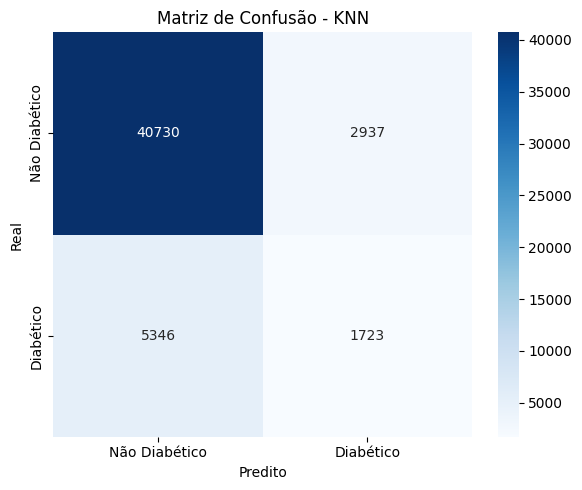


Verdadeiros Negativos: 40730
Falsos Positivos: 2937
Falsos Negativos: 5346
Verdadeiros Positivos: 1723


In [15]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Não Diabético', 'Diabético'],
            yticklabels=['Não Diabético', 'Diabético'])
ax.set_xlabel('Predito')
ax.set_ylabel('Real')
ax.set_title(f'Matriz de Confusão - {best_model_name}')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nVerdadeiros Negativos: {tn}")
print(f"Falsos Positivos: {fp}")
print(f"Falsos Negativos: {fn}")
print(f"Verdadeiros Positivos: {tp}")

**Implicações práticas em saúde pública:**
- **Falsos Negativos (FN):** Pessoas com diabetes não identificadas → risco de não receberem tratamento preventivo (mais grave em saúde)
- **Falsos Positivos (FP):** Pessoas saudáveis classificadas como de risco → exames adicionais desnecessários, mas menos grave

Em triagem de saúde, geralmente priorizamos **recall alto** (minimizar FN), aceitando alguns FP.

### 4C) Otimização de hiperparâmetros

In [16]:
# GridSearch para Regressão Logística
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)
grid_lr.fit(X_train_scaled, y_train)

print(f"Melhores parâmetros (Reg. Logística): {grid_lr.best_params_}")
print(f"Melhor F1-Score CV: {grid_lr.best_score_:.4f}")

Melhores parâmetros (Reg. Logística): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor F1-Score CV: 0.2445


In [17]:
# GridSearch para KNN (com amostragem para acelerar)
# Usando uma amostra estratificada para viabilizar a busca
from sklearn.utils import resample

# Amostra de 20% dos dados de treino para GridSearch
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_scaled), size=int(len(X_train_scaled)*0.2), replace=False)
X_sample = X_train_scaled[sample_idx]
y_sample = y_train[sample_idx]

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_knn.fit(X_sample, y_sample)

print(f"Melhores parâmetros (KNN): {grid_knn.best_params_}")
print(f"Melhor F1-Score CV (amostra): {grid_knn.best_score_:.4f}")

# Retreinar com todos os dados usando os melhores parâmetros
knn_optimized = KNeighborsClassifier(**grid_knn.best_params_)
knn_optimized.fit(X_train_scaled, y_train)

Melhores parâmetros (KNN): {'n_neighbors': 3, 'weights': 'uniform'}
Melhor F1-Score CV (amostra): 0.2784


,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### 4D) Comparação: modelo original vs otimizado

In [18]:
# Avaliação do modelo otimizado
# Comparar F1 no teste para escolher o melhor
y_pred_lr_opt = grid_lr.best_estimator_.predict(X_test_scaled)
y_pred_knn_opt = knn_optimized.predict(X_test_scaled)

f1_lr_opt = f1_score(y_test, y_pred_lr_opt)
f1_knn_opt = f1_score(y_test, y_pred_knn_opt)

if f1_lr_opt > f1_knn_opt:
    optimized_model = grid_lr.best_estimator_
    optimized_name = "Reg. Logística Otimizada"
else:
    optimized_model = knn_optimized
    optimized_name = "KNN Otimizado"

y_pred_opt = optimized_model.predict(X_test_scaled)
y_prob_opt = optimized_model.predict_proba(X_test_scaled)[:, 1]

optimized_f1 = f1_score(y_test, y_pred_opt)
optimized_auc = roc_auc_score(y_test, y_prob_opt)

print("Comparação antes/depois da otimização:")
print(f"\nModelo Original ({best_model_name}):")
print(f"  F1-Score: {f1:.4f}")
print(f"  AUC-ROC: {auc:.4f}")

print(f"\nModelo Otimizado ({optimized_name}):")
print(f"  F1-Score: {optimized_f1:.4f}")
print(f"  AUC-ROC: {optimized_auc:.4f}")

melhoria = (optimized_f1 - f1) * 100
print(f"\nMelhoria no F1-Score: {melhoria:.2f}%")

# Mostrar parâmetros encontrados
print(f"\nParâmetros do modelo otimizado: {grid_knn.best_params_}")

Comparação antes/depois da otimização:

Modelo Original (KNN):
  F1-Score: 0.2938
  AUC-ROC: 0.6836

Modelo Otimizado (KNN Otimizado):
  F1-Score: 0.2938
  AUC-ROC: 0.6836

Melhoria no F1-Score: 0.00%

Parâmetros do modelo otimizado: {'n_neighbors': 3, 'weights': 'uniform'}


**Análise do resultado:** A otimização resultou em 0% de melhoria porque o GridSearchCV encontrou exatamente os mesmos parâmetros que já havíamos selecionado na Questão 2D (K=3, weights='uniform'). Isso demonstra que a análise inicial de variação do K já havia identificado a configuração ótima. O processo de GridSearch serviu para **validar** essa escolha de forma sistemática.

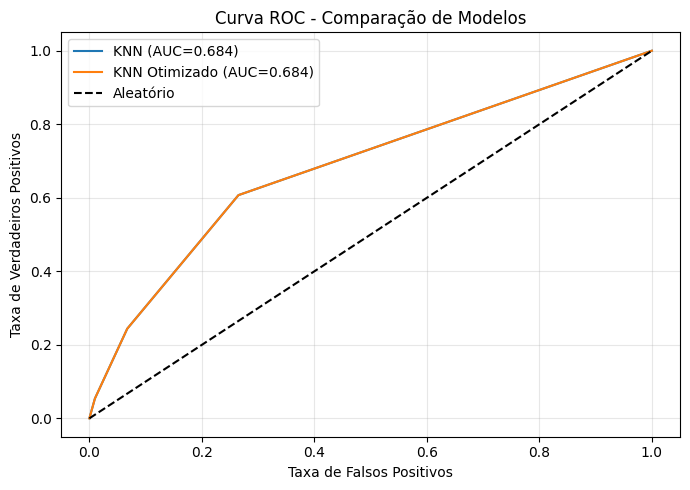

In [19]:
# Curva ROC comparativa
fig, ax = plt.subplots(figsize=(7, 5))

fpr1, tpr1, _ = roc_curve(y_test, y_prob)
fpr2, tpr2, _ = roc_curve(y_test, y_prob_opt)

ax.plot(fpr1, tpr1, label=f'{best_model_name} (AUC={auc:.3f})')
ax.plot(fpr2, tpr2, label=f'{optimized_name} (AUC={optimized_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Aleatório')
ax.set_xlabel('Taxa de Falsos Positivos')
ax.set_ylabel('Taxa de Verdadeiros Positivos')
ax.set_title('Curva ROC - Comparação de Modelos')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusão

**Análise da otimização:** O GridSearchCV encontrou os mesmos parâmetros que já utilizávamos (K=3, weights='uniform'), resultando em 0% de melhoria. Isso indica que a configuração inicial já era ótima dentro do espaço de busca testado.

**Modelo final escolhido:** KNN com K=3 e pesos uniformes.

**Justificativa:** Apesar do KNN apresentar sinais de overfitting (diferença treino-teste de ~0.28), ele ainda obteve o melhor F1-Score no conjunto de teste (0.29) comparado à Regressão Logística (0.24). O baixo desempenho geral de ambos os modelos reflete a dificuldade do problema: o forte desbalanceamento de classes (~86% não-diabéticos) e a natureza das variáveis disponíveis limitam a capacidade preditiva.

**Consideração para saúde pública:** Com recall de ~0.24, o modelo identifica apenas 24% dos casos reais de diabetes. Para uso em triagem, seria recomendável ajustar o threshold de decisão para aumentar o recall, mesmo às custas de mais falsos positivos.